

---


#Step 0: libraries


---



In [57]:
import numpy as np
import seaborn as sns
import pandas as pd
import time
import matplotlib.pyplot as plt
import sklearn
import yfinance as yf
import plotly.graph_objects as go
from scipy.stats import linregress
from sklearn.metrics import mean_squared_error
import plotly.figure_factory as ff
from scipy.spatial import Delaunay
from scipy.interpolate import SmoothBivariateSpline
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
from datetime import datetime
from scipy.stats import norm
!pip install py_vollib
from py_vollib.black_scholes.implied_volatility import implied_volatility
from scipy import optimize
import yfinance as yf
import requests
from scipy.interpolate import griddata
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import silhouette_score
from xgboost import plot_importance
import shap
!pip install xgboost
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.interpolate import interp1d
from scipy.interpolate import BSpline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV


##Downloading data
First of all, it is necessary to work on the stocks data.
I have downloaded data of sp500, shell and total energy every 5 minutes.

In [3]:
sp500= pd.read_csv("sp500 (3).csv").drop(columns=["log_return","RV", "sum_RV","sqrt","log_sqrt"])
shel= pd.read_csv("shel (3).csv").drop(columns=["log_return","RV", "sum_RV","sqrt","log_sqrt"])
total_ener= pd.read_csv("total_ener (1).csv").drop(columns=["log_return","RV", "sum_RV","sqrt","log_sqrt"])
crude_oil= pd.read_csv("crude_oil (1).csv").drop(columns=["log_return","RV", "sum_RV","sqrt","log_sqrt"])
natural_gas= pd.read_csv("natural_oil (1).csv").drop(columns=["log_return","RV", "sum_RV","sqrt","log_sqrt"])
nee= pd.read_csv("nee (3).csv").drop(columns=["log_return","RV", "sum_RV","sqrt","log_sqrt"])

Then, I've calculated the realized variance with a rolling window of 15.
Realized variance is calculated with std of the log returns squared.

In particular I have calculated the realized variance by grouping it in 1h,2h,10,h and 5 min.

In [4]:
def realized_variance(data,window):

  '''It takes as argument data that are the stocks
  and window that is the rolling window on which
  we calculate the realized variance. The final
  output will be the data with entire datsetwith the
  realized variances columns'''

  data= data.set_index("Datetime")
  data.index=pd.to_datetime(data.index)
  data['log_return'] = np.log(data['Close'] / data['Close'].shift(1))
  data['RV'] = data['log_return'].rolling(window).var()
  data['1h']=data.groupby(pd.Grouper(freq='1h'))['RV'].transform('sum')
  data['2h']=data.groupby(pd.Grouper(freq='2h'))['RV'].transform('sum')
  data['10h']=data.groupby(pd.Grouper(freq='10h'))['RV'].transform('sum')
  data['5msqrt']= np.sqrt(data['RV'])
  data['1hsqrt'] = np.sqrt(data['1h'])
  data['2hsqrt'] = np.sqrt(data['2h'])
  data['10hsqrt'] = np.sqrt(data['10h'])
  data.dropna(inplace=True)
  return data

sp500=realized_variance(sp500,15)
shel=realized_variance(shel,15)
total_ener=realized_variance(total_ener,15)
crude_oil=realized_variance(crude_oil,15)
natural_gas=realized_variance(natural_gas,15)
nee=realized_variance(nee,15)



---


#Step 1: Estimation of H



---


H calculation using p-th variation and Gatheral's log scale.

## P-th variation

In [6]:
def p_variation(ts, p=2, m_list=[1,2,4,8,16]):

    '''It takes as argument ts that is the realized variance,
    the p term and a list of possible coeefficients for m.'''

    V = []
    m_used = []
    for m in m_list:
        subsample = ts[::m]
        if len(subsample) < 2:
            continue
        diff = np.diff(subsample)
        v = np.sum(np.abs(diff) ** p)
        if v > 0:
            V.append(v)
            m_used.append(m)
    log_m = np.log(m_used)
    log_V = np.log(V)
    slope, _, _, _, _ = linregress(log_m, log_V)
    H = slope / p
    return H

H_pvar_sp500 = p_variation(sp500["RV"], p=2)
H_pvar_shel = p_variation(shel["RV"], p=2)
H_pvar_total_ener = p_variation(total_ener["RV"], p=2)
H_pvar_crude_oil = p_variation(crude_oil["RV"], p=2)
H_pvar_natural_gas = p_variation(natural_gas["RV"], p=2)
H_pvar_nee = p_variation(nee["RV"], p=2)


##Gatheral's log scale

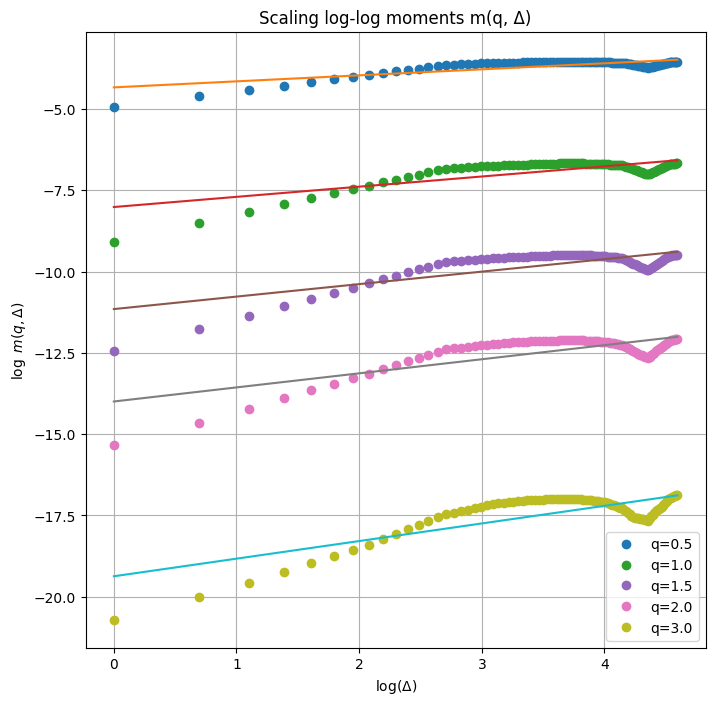

R² for ζ(q) vs q linearity for sp500 5m: 0.9536


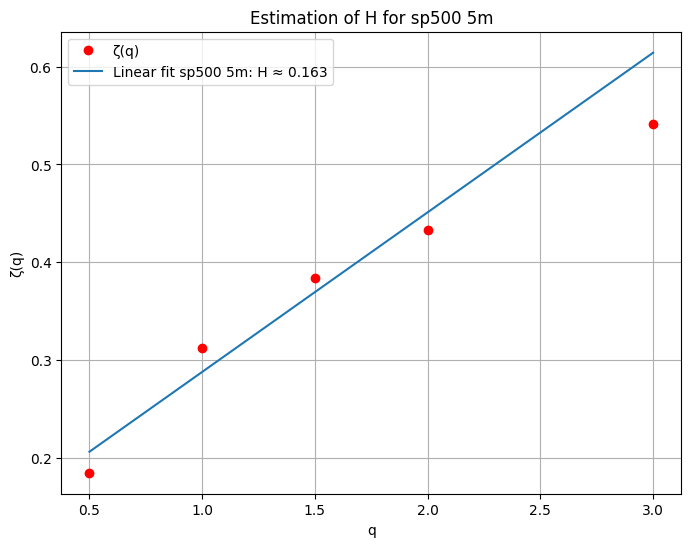

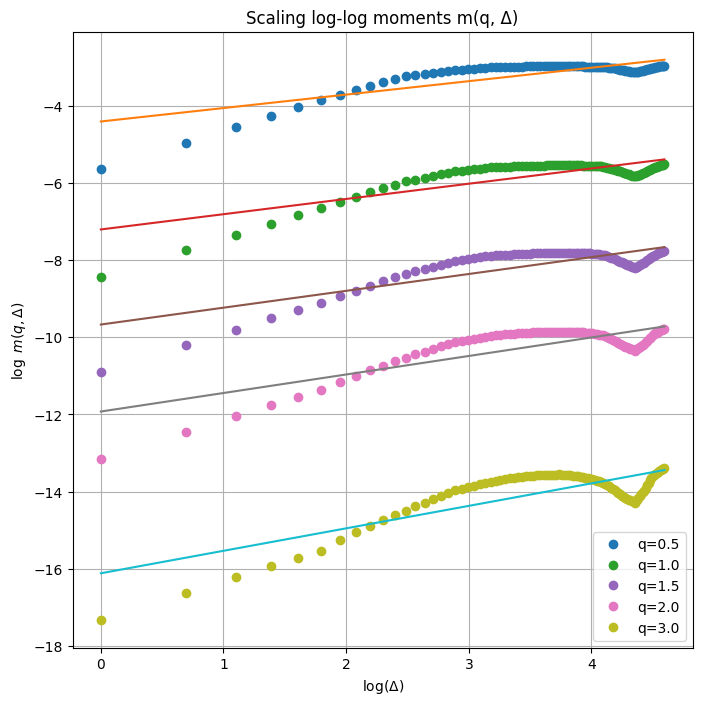

R² for ζ(q) vs q linearity for sp500 1h: 0.9994


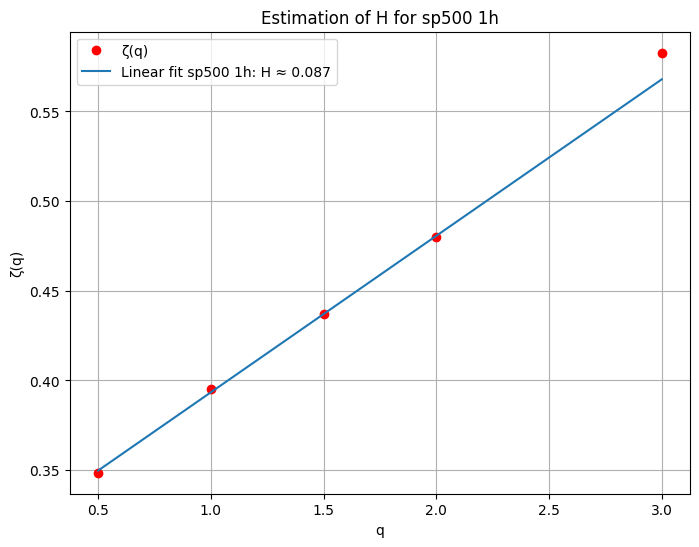

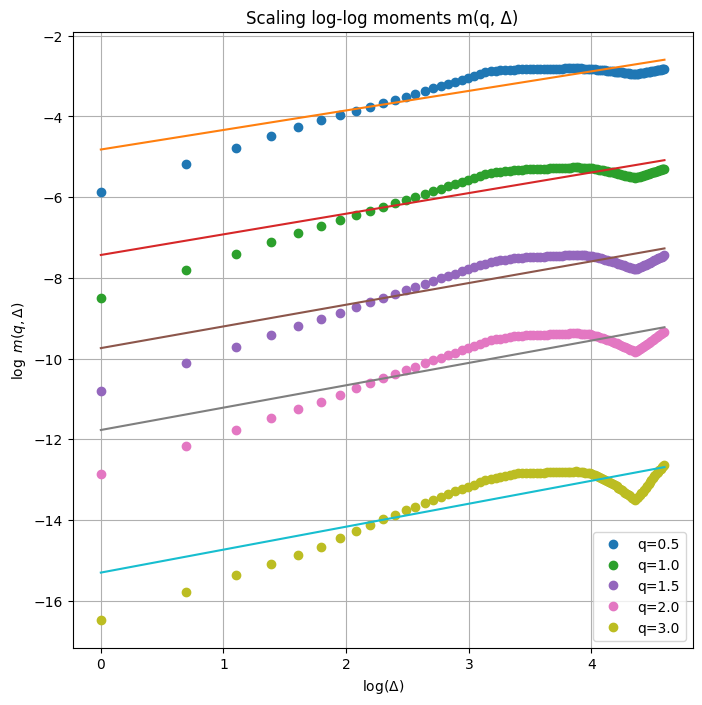

R² for ζ(q) vs q linearity for sp500 2h: 0.9889


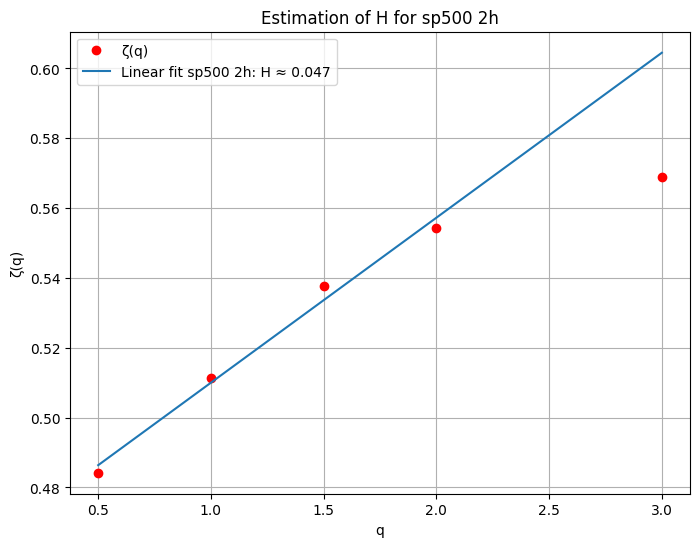

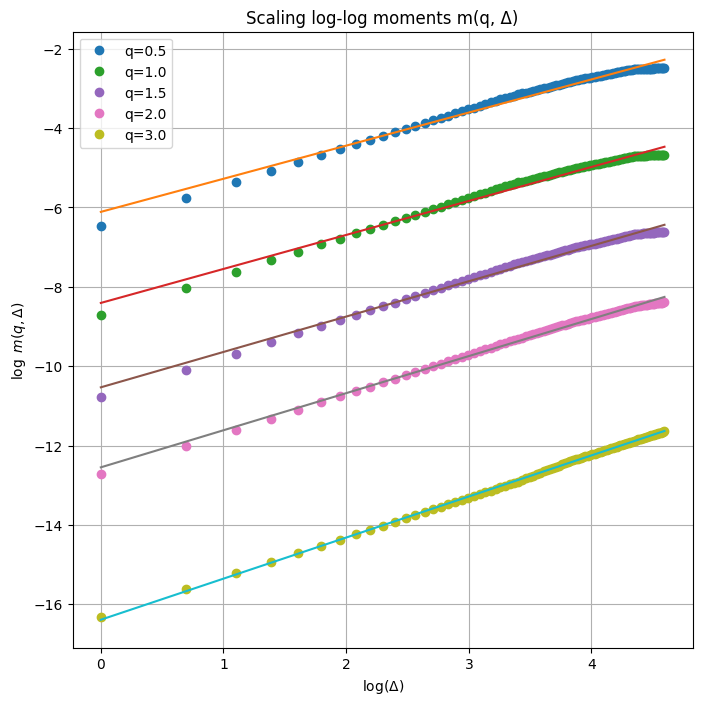

R² for ζ(q) vs q linearity for sp500 10h: 0.9803


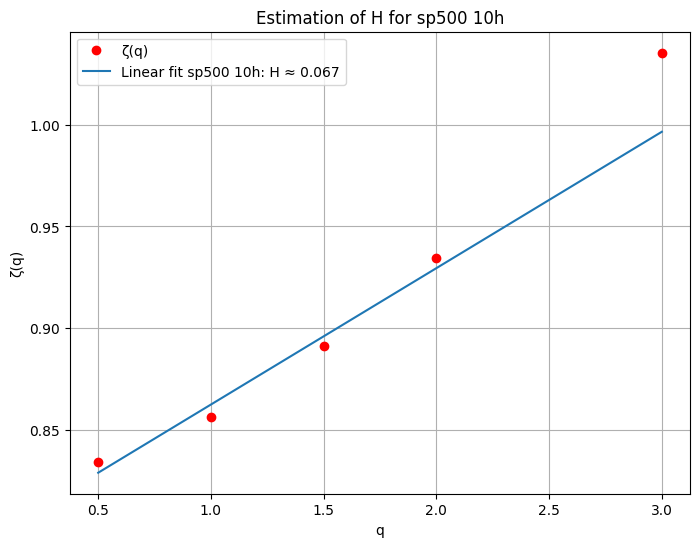

In [8]:
def del_Raw(q, lags, series):

    '''this function takes q that is an integer
    representing the q-moments, lags that are integers
    and series that is our data'''

    return [np.mean(np.abs(series - series.shift(lag)) ** q) for lag in lags]

def gatheral_approach(data, sqrt,ticker):
  qVec = np.array([.5, 1, 1.5, 2, 3])
  x = np.arange(1, 100)


  zeta_q = []
  plt.figure(figsize=(8, 8))
  plt.xlabel('$\log(\Delta)$')
  plt.ylabel('$\log\ m(q, \Delta)$')

  for q in qVec:
    y_vals = del_Raw(q, x, sqrt)
    logx = np.log(x)
    logy = np.log(y_vals)
    plt.plot(logx, logy, 'o', label=f'q={q}')
    slope, intercept = np.polyfit(logx, logy, 1)

    fig1=plt.plot(logx, slope * logx + intercept)
    zeta_q.append(slope)


  plt.legend()
  plt.title("Scaling log-log moments m(q, Δ)")
  plt.grid(True)
  plt.show()

  # Fit lineare di zeta_q su q ∈ [0.5, 2]
  coeffs = np.polyfit(qVec[:4], zeta_q[:4], 1)
  hurst_est = coeffs[0]

  y_pred_zeta = coeffs[0] * qVec[:4] + coeffs[1]
  ss_res_zeta = np.sum((zeta_q[:4] - y_pred_zeta) ** 2)
  ss_tot_zeta = np.sum((zeta_q[:4] - np.mean(zeta_q[:4])) ** 2)
  r_squared_zeta = 1 - (ss_res_zeta / ss_tot_zeta)

  print(f"R² for ζ(q) vs q linearity for {ticker}: {r_squared_zeta:.4f}")

  # Plot ζq vs q
  fig2=plt.figure(figsize=(8, 6))
  plt.plot(qVec, zeta_q, 'or', label='ζ(q)')
  plt.plot(qVec, coeffs[0] * qVec + coeffs[1], label=f'Linear fit {ticker}: H ≈ {hurst_est:.3f}')
  plt.xlabel('q')
  plt.ylabel('ζ(q)')
  plt.title(f'Estimation of H for {ticker}')
  plt.legend()
  plt.grid(True)
  plt.show()

  return hurst_est

H_gatheral_sp500_5m = gatheral_approach(sp500,sp500["5msqrt"],'sp500 5m')
H_gatheral_sp500_1h = gatheral_approach(sp500,sp500["1hsqrt"],'sp500 1h')
H_gatheral_sp500_2h = gatheral_approach(sp500,sp500["2hsqrt"],'sp500 2h')
H_gatheral_sp500_10h = gatheral_approach(sp500,sp500["10hsqrt"],'sp500 10h')


In [10]:
VIX= yf.Ticker("^VIX")
VIX=VIX.history(start="2024-06-16",end="2025-06-16",period="5d", interval="1d")  # Last 5 days, 5-minute data



---


#Step 3: Rough Bergomi


---



##Data preparation for atm skew

###Downloading both call and put options

In [11]:
ticker = yf.Ticker("SPY")
spot_history = ticker.history()
spot=spot_history["Close"].iloc[-2]

In [12]:
df=pd.read_csv('options_data.csv')

###Implied volatility from market

In [13]:
df_sorted=df.sort_values(by=["Type","strike","T"])


In [15]:
K=df_sorted["strike"].values
T=df_sorted["T"].values
IV=df_sorted["impliedVolatility"].values

K_grid= np.linspace(K.min(),K.max(),100)
T_grid= np.linspace(T.min(),T.max(),100)
K_mesh,T_mesh=np.meshgrid(K_grid,T_grid)
IV_surf= griddata((K,T), IV, (K_mesh,T_mesh), method="cubic")

fig = go.Figure(data=[go.Surface(z=IV_surf, x=K_mesh, y=T_mesh)])
fig.update_layout(title='Implied Volatility Surface (Market)',
                  scene=dict(xaxis_title='Strike',
                             yaxis_title='Time to Maturity (T)',
                             zaxis_title='Implied Volatility'))
fig.show()


##ATM skew from market



In [16]:
df_atm=df_sorted[np.abs(df["log_moneyness"]) < 0.2]

/tmp/ipython-input-16-1220145292.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [42]:
def grid_for_atm(K,T,IV,method):

  '''It takes as argument K,T, IV and the method
  according which the interpolation is done and it returns
  a smooth surface for K, T and IV for better plotting the atm skew.'''

  K_atm=K
  T_atm=T
  IV_atm=IV

  K_atm_grid= np.linspace(K_atm.min(),K_atm.max(),100)
  T_atm_grid= np.linspace(T_atm.min(),T_atm.max(),100)
  K_atm_mesh,T_atm_mesh=np.meshgrid(K_atm_grid,T_atm_grid)
  IV_atm_surf= griddata((K_atm,T_atm), IV_atm, (K_atm_mesh,T_atm_mesh), method=method)

  return K_atm_mesh,T_atm_mesh,IV_atm_surf

K_atm_mesh,T_atm_mesh,IV_atm_surf=creating_smooth(df_atm["strike"].values,df_atm["T"].values,df_atm["impliedVolatility"].values,"cubic")

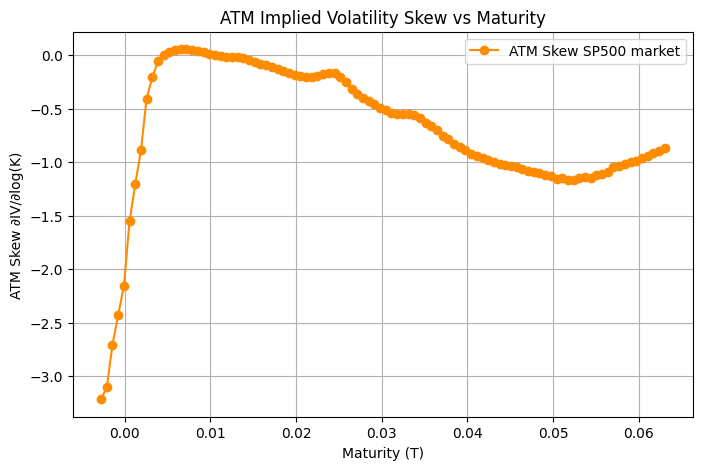

In [19]:
def local_linear_atm_skew(T_grid, IV_surf, log_moneyness, window, ticker):
    """
    It calculates the atm skew with linear regression
    on log-moneyness near 0.2 taking as arguments the array
    created through the function  grid_for_atm.'''
    """
    atm_skew = []
    unique_T = np.unique(T_grid)

    for t in unique_T:
        ##masking for same maturity
        mask = np.isclose(T_grid, t)
        lm_slice = log_moneyness[mask]
        iv_slice = IV_surf[mask]

        # removing nan's
        valid = ~np.isnan(iv_slice) & ~np.isnan(lm_slice)
        lm_slice = lm_slice[valid]
        iv_slice = iv_slice[valid]

        # only points atm
        local_mask = np.abs(lm_slice) < window
        lm_local = lm_slice[local_mask]
        iv_local = iv_slice[local_mask]
        if len(lm_local) < 3:
            continue

        # for applying sklearn we need to reshape
        X = lm_local.reshape(-1, 1)
        y = iv_local
        model = LinearRegression()
        model.fit(X, y)

        # slope = skew
        skew = model.coef_[0]
        atm_skew.append((t, skew))

    atm_skew = np.array(atm_skew)
    if len(atm_skew) == 0:
        print("No estimation")
        return None

    T_vals = atm_skew[:, 0]
    skew_vals = atm_skew[:, 1]

    plt.figure(figsize=(8, 5))
    plt.plot(T_vals, skew_vals, marker='o', linestyle='-', color='darkorange', label=f'ATM Skew {ticker}')
    plt.xlabel("Maturity (T)")
    plt.ylabel("ATM Skew ∂IV/∂log(K)")
    plt.title("ATM Implied Volatility Skew vs Maturity")
    plt.grid(True)
    plt.legend()
    plt.show()

    return atm_skew

atm_skew = local_linear_atm_skew(
    T_grid=T_atm_mesh,
    IV_surf=IV_atm_surf,
    log_moneyness=np.log(K_atm_mesh / spot),
    window=0.2,
    ticker="SP500 market"
)


##Rough Bergomi simulation

In [20]:
def forward_variance(T, IV):
    """
    Estimate the forward variance curve xi_0(t) from ATM implied vol surface.

    Parameters:
        T : array-like
            Maturities (e.g., in years).
        IV : array-like
            ATM implied volatilities corresponding to T.

    Returns:
        t_dense : numpy array
            Interpolated maturities.
        xi_0 : numpy array
            Forward variance curve xi_0(t).
    """
    # Total variance: sigma^2(T) * T
    total_var = (IV ** 2) * T

    # Interpolate total variance
    interp_func = BSpline.construct_fast(T.values, total_var.values,k=2)
    t_dense = np.linspace(T.min(), T.max(), 200)
    total_var_dense = interp_func(t_dense)

    # Compute forward variance: d/dt [ total variance ]
    dt = t_dense[1] - t_dense[0]
    xi_0 = np.gradient(total_var_dense, dt)

    return t_dense, xi_0
t_dense, xi_0=forward_variance(df["T"], df["impliedVolatility"])


In [21]:
def simulate_rBergomi(H, eta, rho, T, t_forw, S0, x, N=50, M=500):

    '''it takes as argument H,eta,rho, T (time to maturity),
    t_forw that is the forward variance times, S0 that is the spot
    and x the forward curve values. N and M allow the Monte Carlo Simulation.
    It returns the S_sim that is the spot path and v that is the variance path.
    The simulation follows the hybrid scheme.'''

    dt = T / N
    times = np.linspace(0, T, N+1)
    gamma = H + 0.5

    dW = np.random.normal(0, np.sqrt(dt), (M, N))
    dZ = rho * dW + np.sqrt(1 - rho**2) * np.random.normal(0, np.sqrt(dt), size=(M, N))

    # Fractional Gaussian noise integration (Hybrid)
    G = np.zeros((M, N+1))
    for j in range(1, N+1):
        G[:, j] = G[:, j-1] + dt**gamma * dW[:, j-1]

    # Extract initial forward variance (approximation using ATM IVs)
      # Volatility process
    xi_0_interp_func = interp1d(t_forw, x, kind='linear', fill_value="extrapolate")

    v = np.zeros((M, N+1))
    for i in range(N+1):
        time_i = times[i]
        xi_0_t_i = xi_0_interp_func(time_i)
        v[:, i] = xi_0_t_i*np.exp(eta * G[:, i] - 0.5 * eta**2 * time_i**(2 * H))
        v[:, i] = np.maximum(v[:, i], 1e-10)

    # Simulate log-price process
    S = np.zeros((M, N+1))
    S[:, 0] = S0
    for i in range(N):
        S[:, i+1] = S[:, i] * np.exp(-0.5 * v[:, i] * dt + np.sqrt(v[:, i]) * dZ[:, i])

    return S, v, times

According to maturities, it has been performed a split for considering the multiscale value of H.

In [23]:
df_5m = df[df["T"] <= 0.015]
df_1h = df[(df["T"] < 0.01) & (df["T"] > 0.00157)]
df_2h = df[(df["T"] < 0.03) & (df["T"] > 0.01)]
df_10h = df[df["T"] > 0.03]

###Rough Bergomi 5m

In [31]:
# === Rough Bergomi 5m ===
bounds_iv=(0.001, 3.0)

def bs_price_vectorized(S0, K, T, sigma, options, r=0.0):
    '''This function calculates the BS price'''
    for opt_type in options:

      if opt_type=="Call":
        d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
      elif opt_type=="Put":
        d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)


def iv_objective_scalar(sigma, spot, K, T, price,options, r=0):
    '''This is the function to minimize, the difference between
    the BS price and the price inserted in the function'''
    if sigma <= 0:
        return 1e10
    return (bs_price_vectorized(spot, K, T, sigma, r, options) - price) ** 2

def objective_function_fast(eta, rho, T_values, K_values, options, spot, H, x, r=0.0, N=50, M=200):
    ''' This function calculates the implied volatility of rBergomi
    by minimizing the ffunction iv_objective_scalar'''
    model_iv = np.zeros(len(T_values))

    for i, (T_, K_, opt_type) in enumerate(zip(T_values, K_values, options)):
        print(f"[{i+1}/{len(T_values)}] Simulating for T = {T_:.3f}")

        S_sim, _, _ = simulate_rBergomi(H=H, eta=eta, rho=rho, T=T_, t_forw=t_dense, S0=spot, x=x, N=N, M=M)
        S_T = S_sim[:, -1]

        if opt_type == "Call":
            payoff = np.maximum(S_T - K_, 0)
        elif opt_type == "Put":
            payoff = np.maximum(K_ - S_T, 0)
        else:
            raise ValueError(f"Unknown option type: {opt_type}")

        price = np.mean(payoff)

        result = optimize.minimize_scalar(
            iv_objective_scalar,
            bounds=bounds_iv,
            method='bounded',
            args=(spot, K_, T_, price, r, options)
        )

        if result.success:
            model_iv[i] = result.x
        else:
            model_iv[i] = np.nan

    return model_iv

# Calcolo della superficie IV usando Rough Bergomi con H da dati a 5 minuti
model_iv_5m = objective_function_fast(
    eta=1.9,
    rho=-0.9,
    T_values=df_5m["T"],
    K_values=df_5m["strike"],
    options=df_5m["Type"],
    spot=spot,
    H=H_gatheral_sp500_5m,
    x=xi_0
)
df_rough=df.copy()
df_5m["impliedVolatility_rough_5m"]=model_iv_5m
df_rough.loc[df_5m.index, "impliedVolatility_rough_5m"] = model_iv_5m


[1/1073] Simulating for T = -0.003
[2/1073] Simulating for T = -0.003
[3/1073] Simulating for T = -0.003
[4/1073] Simulating for T = -0.003
[5/1073] Simulating for T = -0.003
[6/1073] Simulating for T = -0.003
[7/1073] Simulating for T = -0.003
[8/1073] Simulating for T = -0.003
[9/1073] Simulating for T = -0.003
[10/1073] Simulating for T = -0.003
[11/1073] Simulating for T = -0.003


/tmp/ipython-input-21-670500134.py:13: RuntimeWarning:

invalid value encountered in sqrt

/tmp/ipython-input-21-670500134.py:14: RuntimeWarning:

invalid value encountered in sqrt

/tmp/ipython-input-21-670500134.py:19: RuntimeWarning:

invalid value encountered in scalar power

/tmp/ipython-input-21-670500134.py:29: RuntimeWarning:

invalid value encountered in scalar power

/tmp/ipython-input-31-1304447542.py:9: RuntimeWarning:

invalid value encountered in sqrt

/tmp/ipython-input-31-1304447542.py:10: RuntimeWarning:

invalid value encountered in sqrt



[12/1073] Simulating for T = -0.003
[13/1073] Simulating for T = -0.003
[14/1073] Simulating for T = -0.003
[15/1073] Simulating for T = -0.003
[16/1073] Simulating for T = -0.003
[17/1073] Simulating for T = -0.003
[18/1073] Simulating for T = -0.003
[19/1073] Simulating for T = -0.003
[20/1073] Simulating for T = -0.003
[21/1073] Simulating for T = -0.003
[22/1073] Simulating for T = -0.003
[23/1073] Simulating for T = -0.003
[24/1073] Simulating for T = -0.003
[25/1073] Simulating for T = -0.003
[26/1073] Simulating for T = -0.003
[27/1073] Simulating for T = -0.003
[28/1073] Simulating for T = -0.003
[29/1073] Simulating for T = -0.003
[30/1073] Simulating for T = -0.003
[31/1073] Simulating for T = -0.003
[32/1073] Simulating for T = -0.003
[33/1073] Simulating for T = -0.003
[34/1073] Simulating for T = -0.003
[35/1073] Simulating for T = -0.003
[36/1073] Simulating for T = -0.003
[37/1073] Simulating for T = -0.003
[38/1073] Simulating for T = -0.003
[39/1073] Simulating for T =

/tmp/ipython-input-31-1304447542.py:9: RuntimeWarning:

divide by zero encountered in scalar divide



[208/1073] Simulating for T = 0.000
[209/1073] Simulating for T = 0.000
[210/1073] Simulating for T = 0.000
[211/1073] Simulating for T = 0.000
[212/1073] Simulating for T = 0.000
[213/1073] Simulating for T = 0.000
[214/1073] Simulating for T = 0.000
[215/1073] Simulating for T = 0.000
[216/1073] Simulating for T = 0.000
[217/1073] Simulating for T = 0.000
[218/1073] Simulating for T = 0.000
[219/1073] Simulating for T = 0.000
[220/1073] Simulating for T = 0.000
[221/1073] Simulating for T = 0.000
[222/1073] Simulating for T = 0.000
[223/1073] Simulating for T = 0.000
[224/1073] Simulating for T = 0.000
[225/1073] Simulating for T = 0.000
[226/1073] Simulating for T = 0.000
[227/1073] Simulating for T = 0.000
[228/1073] Simulating for T = 0.000
[229/1073] Simulating for T = 0.000
[230/1073] Simulating for T = 0.000
[231/1073] Simulating for T = 0.000
[232/1073] Simulating for T = 0.000
[233/1073] Simulating for T = 0.000
[234/1073] Simulating for T = 0.000
[235/1073] Simulating for T 

###Rough Bergomi 1h

In [32]:
model_iv_1h = objective_function_fast(
    eta=1.9,
    rho=-0.9,
    T_values=df_1h["T"],
    K_values=df_1h["strike"],
    options=df_1h["Type"],
    spot=spot,
    H=H_gatheral_sp500_1h,
    x=xi_0
)
df_1h["impliedVolatility_rough_1h"]=model_iv_1h

[1/532] Simulating for T = 0.005
[2/532] Simulating for T = 0.005
[3/532] Simulating for T = 0.005
[4/532] Simulating for T = 0.005
[5/532] Simulating for T = 0.005
[6/532] Simulating for T = 0.005
[7/532] Simulating for T = 0.005
[8/532] Simulating for T = 0.005
[9/532] Simulating for T = 0.005
[10/532] Simulating for T = 0.005
[11/532] Simulating for T = 0.005
[12/532] Simulating for T = 0.005
[13/532] Simulating for T = 0.005
[14/532] Simulating for T = 0.005
[15/532] Simulating for T = 0.005
[16/532] Simulating for T = 0.005
[17/532] Simulating for T = 0.005
[18/532] Simulating for T = 0.005
[19/532] Simulating for T = 0.005
[20/532] Simulating for T = 0.005
[21/532] Simulating for T = 0.005
[22/532] Simulating for T = 0.005
[23/532] Simulating for T = 0.005
[24/532] Simulating for T = 0.005
[25/532] Simulating for T = 0.005
[26/532] Simulating for T = 0.005
[27/532] Simulating for T = 0.005
[28/532] Simulating for T = 0.005
[29/532] Simulating for T = 0.005
[30/532] Simulating for

###Rough Bergomi 2h


In [33]:
model_iv_2h = objective_function_fast(
    eta=1.9,
    rho=-0.9,
    T_values=df_2h["T"],
    K_values=df_2h["strike"],
    options=df_2h["Type"],
    spot=spot,
    H=H_gatheral_sp500_2h,
    x=xi_0
)
df_2h["impliedVolatility_rough_2h"]=model_iv_2h

[1/800] Simulating for T = 0.014
[2/800] Simulating for T = 0.014
[3/800] Simulating for T = 0.014
[4/800] Simulating for T = 0.014
[5/800] Simulating for T = 0.014
[6/800] Simulating for T = 0.014
[7/800] Simulating for T = 0.014
[8/800] Simulating for T = 0.014
[9/800] Simulating for T = 0.014
[10/800] Simulating for T = 0.014
[11/800] Simulating for T = 0.014
[12/800] Simulating for T = 0.014
[13/800] Simulating for T = 0.014
[14/800] Simulating for T = 0.014
[15/800] Simulating for T = 0.014
[16/800] Simulating for T = 0.014
[17/800] Simulating for T = 0.014
[18/800] Simulating for T = 0.014
[19/800] Simulating for T = 0.014
[20/800] Simulating for T = 0.014
[21/800] Simulating for T = 0.014
[22/800] Simulating for T = 0.014
[23/800] Simulating for T = 0.014
[24/800] Simulating for T = 0.014
[25/800] Simulating for T = 0.014
[26/800] Simulating for T = 0.014
[27/800] Simulating for T = 0.014
[28/800] Simulating for T = 0.014
[29/800] Simulating for T = 0.014
[30/800] Simulating for

###Rough Bergomi 10h

In [34]:
model_iv_10h = objective_function_fast(
    eta=1.9,
    rho=-0.9,
    T_values=df_10h["T"],
    K_values=df_10h["strike"],
    options=df_10h["Type"],
    spot=spot,
    H=H_gatheral_sp500_10h,
    x=xi_0
)
df_10h["impliedVolatility_rough_10h"]=model_iv_10h

[1/765] Simulating for T = 0.033
[2/765] Simulating for T = 0.033
[3/765] Simulating for T = 0.033
[4/765] Simulating for T = 0.033
[5/765] Simulating for T = 0.033
[6/765] Simulating for T = 0.033
[7/765] Simulating for T = 0.033
[8/765] Simulating for T = 0.033
[9/765] Simulating for T = 0.033
[10/765] Simulating for T = 0.033
[11/765] Simulating for T = 0.033
[12/765] Simulating for T = 0.033
[13/765] Simulating for T = 0.033
[14/765] Simulating for T = 0.033
[15/765] Simulating for T = 0.033
[16/765] Simulating for T = 0.033
[17/765] Simulating for T = 0.033
[18/765] Simulating for T = 0.033
[19/765] Simulating for T = 0.033
[20/765] Simulating for T = 0.033
[21/765] Simulating for T = 0.033
[22/765] Simulating for T = 0.033
[23/765] Simulating for T = 0.033
[24/765] Simulating for T = 0.033
[25/765] Simulating for T = 0.033
[26/765] Simulating for T = 0.033
[27/765] Simulating for T = 0.033
[28/765] Simulating for T = 0.033
[29/765] Simulating for T = 0.033
[30/765] Simulating for

##Bergomi implied volatility surface

##Plotting iv 5m

In [37]:
df_rough=df.copy()
df_rough.loc[df_1h.index, "impliedVolatility_rough"] = model_iv_1h
df_rough.loc[df_5m.index, "impliedVolatility_rough"] = model_iv_5m
df_rough.loc[df_2h.index, "impliedVolatility_rough"] = model_iv_2h
df_rough.loc[df_10h.index, "impliedVolatility_rough"] = model_iv_10h
df_rough=df_rough.bfill()
df_rough_sorted=df_rough.sort_values(by=["Type","strike","T"])

In [38]:
K=df_rough_sorted["strike"]
T=df_rough_sorted["T"]

K_grid= np.linspace(K.min(),K.max(),100)
T_grid= np.linspace(T.min(),T.max(),100)
K_mesh,T_mesh=np.meshgrid(K_grid,T_grid)
IV_surf_rough= griddata((K,T), df_rough_sorted["impliedVolatility_rough"], (K_mesh,T_mesh), method="linear")

In [39]:
# Corrected plotting for rBergomi surface
fig = go.Figure(data=[go.Surface(z=IV_surf_rough, x=K_mesh, y=T_mesh)]) # Use K_mesh and T_mesh
fig.update_layout(title='Implied Volatility Surface (rBergomi Model) H 5m', # Added H 5m for clarity
                  scene=dict(xaxis_title='Strike',
                             yaxis_title='Time to Maturity (T)',
                             zaxis_title='Implied Volatility'))
fig.show()

##ATM SKEW ROUGH BERGOMI

In [40]:
df_atm_rough = df_rough_sorted[np.abs(df_rough_sorted["log_moneyness"]) < 0.2]
df_atm_rough_n = df_rough[np.abs(df_rough["log_moneyness"]) < 0.2]

In [43]:
K_atm_rough,T_atm_rough,IV_atm_rough=grid_for_atm(df_atm_rough["strike"].values,df_atm_rough["T"].values,df_atm_rough["impliedVolatility_rough"].values,"linear")

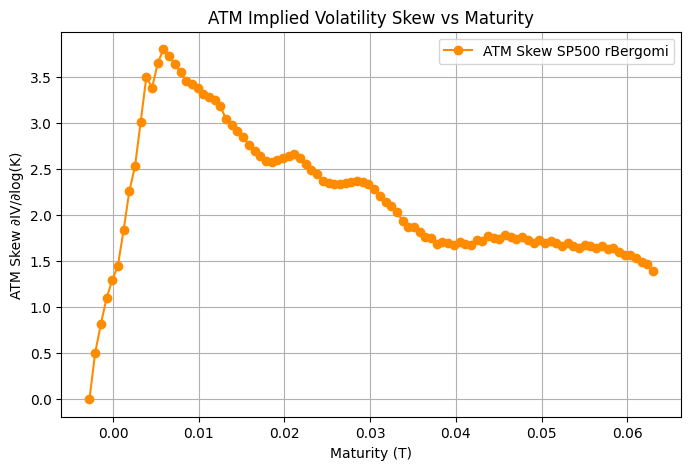

In [44]:
atm_skew_rough_5m=local_linear_atm_skew(T_atm_rough,IV_atm_rough,np.log(K_atm_rough/spot),0.2,"SP500 rBergomi")

# Step 4: Machine learning implied volatility

###Feature engineering

###Greeks

In [45]:
def greeks(S0, K, T, sigma, r=0):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    delta = norm.cdf(d1)
    gamma = norm.pdf(d1) / (S0 * sigma * np.sqrt(T))
    theta = -(S0 * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2)
    vega = S0 * np.sqrt(T) * norm.pdf(d1)
    return [delta,gamma,theta,vega]

delta=greeks(spot,df_atm_rough_n["strike"],df_atm_rough_n["T"],df_atm_rough_n["impliedVolatility_rough"])[0]
gamma=greeks(spot,df_atm_rough_n["strike"],df_atm_rough_n["T"],df_atm_rough_n["impliedVolatility_rough"])[1]
theta=greeks(spot,df_atm_rough_n["strike"],df_atm_rough_n["T"],df_atm_rough_n["impliedVolatility_rough"])[2]
vega=greeks(spot,df_atm_rough_n["strike"],df_atm_rough_n["T"],df_atm_rough_n["impliedVolatility_rough"])[3]

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning:

invalid value encountered in sqrt



###Manipulation of data
####Interpolation of VIX values and calculation of the curvature

For avoiding data leakage I have used other implied volatilities wrt the market ones

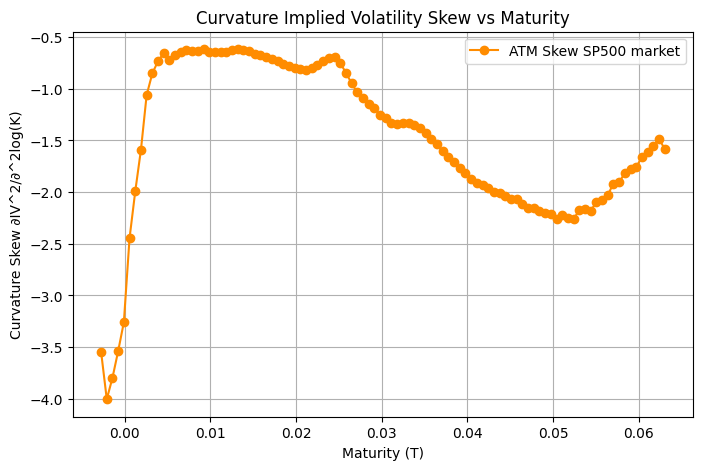

In [46]:
def polynomial_curvature(T_grid, IV_surf, log_moneyness, window, ticker):
    """
    It calculates the curvature of the atm skew with linear regression
    on log-moneyness near 0.2 and it returns the plot.
    """
    curvature = []
    unique_T = np.unique(T_grid)

    for t in unique_T:
        ##masking for same maturity
        mask = np.isclose(T_grid, t)
        lm_slice = log_moneyness[mask]
        iv_slice = IV_surf[mask]

        # removing nan's
        valid = ~np.isnan(iv_slice) & ~np.isnan(lm_slice)
        lm_slice = lm_slice[valid]
        iv_slice = iv_slice[valid]

        # only points atm
        local_mask = np.abs(lm_slice) < window
        lm_local = lm_slice[local_mask]
        iv_local = iv_slice[local_mask]
        if len(lm_local) < 3:
            continue

        # for applying sklearn we need to reshape
        X = lm_local.reshape(-1, 1)
        y = iv_local

        poly = PolynomialFeatures(degree=2)
        X_poly = poly.fit_transform(X)
        model = LinearRegression()
        model=model.fit(X_poly, y)

        # slope = skew
        skew = 2*model.coef_[1]
        curvature.append((t, skew))

    curvature = np.array(curvature)
    if len(curvature) == 0:
        print("No estimation")
        return None

    T_vals = curvature[:, 0]
    skew_vals = curvature[:, 1]

    plt.figure(figsize=(8, 5))
    plt.plot(T_vals, skew_vals, marker='o', linestyle='-', color='darkorange', label=f'ATM Skew {ticker}')
    plt.xlabel("Maturity (T)")
    plt.ylabel("Curvature Skew ∂IV^2/∂^2log(K)")
    plt.title("Curvature Implied Volatility Skew vs Maturity")
    plt.grid(True)
    plt.legend()
    plt.show()

    return curvature

smile_curvature = polynomial_curvature(
    T_grid=T_atm_rough,
    IV_surf=IV_atm_surf,
    log_moneyness=np.log(K_atm_rough / spot),
    window=0.2,
    ticker="SP500 market"
)

In [48]:
data=df_atm_rough_n.copy()
y=data["impliedVolatility"]
data["mid_price"]=(data["bid"]+data["ask"])/2
data["delta"]=delta
data["vega"]=vega
columns_to_drop = ["Unnamed: 0","lastTradeDate","impliedVolatility","Type", "contractSymbol","percentChange", "bid","ask","change","contractSize", "currency", "openInterest", "inTheMoney", "expiration"]
data = data.drop(columns=columns_to_drop)

#Interpolation of VIX
vix_df_reset = VIX.reset_index(drop=True)

# Select the 'Close' column from the VIX data as the values to interpolate (fp)
vix_values = vix_df_reset['Close'].values

# The original index of the VIX data serves as the x-coordinates for the VIX values (xp)
vix_index = np.arange(len(vix_df_reset))

# The target x-coordinates for interpolation are based on the length of the 'data' DataFrame (x)
target_index = np.linspace(0, len(vix_df_reset) - 1, len(data))

# Perform the interpolation using the corrected xp and fp
vix_interp = np.interp(
    target_index,
    vix_index,
    vix_values
)
smile_curvature_interp = np.interp(
    data["T"].values,  # Interpolate based on maturities in the data DataFrame
    smile_curvature[:, 0], # Original maturities for curvature
    smile_curvature[:, 1]  # Original curvature values
)

data["curvature"]=smile_curvature_interp
data["VIX"] = vix_interp
data=data.bfill()
corr=data.corr()

In [50]:
tscv= TimeSeriesSplit(n_splits=3)
for i, (train_index, test_index) in enumerate(tscv.split(data)):
    print(f"Split {i + 1}")
    print("Train indices:", train_index)
    print("Test indices:", test_index)

for train_index, test_index in tscv.split(data):
    train_df = data.iloc[train_index]
    test_df = data.iloc[test_index]

Split 1
Train indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240

In [51]:
for train_index, test_index in tscv.split(y):
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

In [52]:
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_df)
test_data_scaled = scaler.transform(test_df)

# Try different PCA components and compute reconstruction error
component_list = [2,5,3]
reconstruction_errors = {}

for n in component_list:
    pca = PCA(n_components=n, random_state=42, svd_solver='full')
    train_pca = pca.fit_transform(train_data_scaled)
    train_reconstructed = pca.inverse_transform(train_pca)
    mse = mean_squared_error(train_data_scaled, train_reconstructed)
    reconstruction_errors[n] = mse

best_n_components = min(reconstruction_errors, key=reconstruction_errors.get)
print("Best n_components:", best_n_components)
print("MSE for each:", reconstruction_errors)

pca = PCA(n_components=best_n_components).fit(train_data_scaled)
explained_var_ratio = np.cumsum(pca.explained_variance_ratio_)
explained_var_ratio

Best n_components: 5
MSE for each: {2: 0.4372653255321145, 5: 0.10093895493797853, 3: 0.27418949634174006}


array([0.28866343, 0.56273467, 0.7258105 , 0.81688043, 0.89906105])

In [61]:
#dding the PCA to the dataset as features
train_pca_transformed = pca.transform(train_data_scaled)
test_pca_transformed = pca.transform(test_data_scaled)
train_df["pca1"]=train_pca_transformed[:,0]
train_df["pca2"]=train_pca_transformed[:,1]
train_df["pca3"]=train_pca_transformed[:,2]
train_df["pca4"]=train_pca_transformed[:,3]
train_df["pca5"]=train_pca_transformed[:,4]

test_df["pca1"]=test_pca_transformed[:,0]
test_df["pca2"]=test_pca_transformed[:,1]
test_df["pca3"]=test_pca_transformed[:,2]
test_df["pca4"]=test_pca_transformed[:,3]
test_df["pca5"]=test_pca_transformed[:,4]

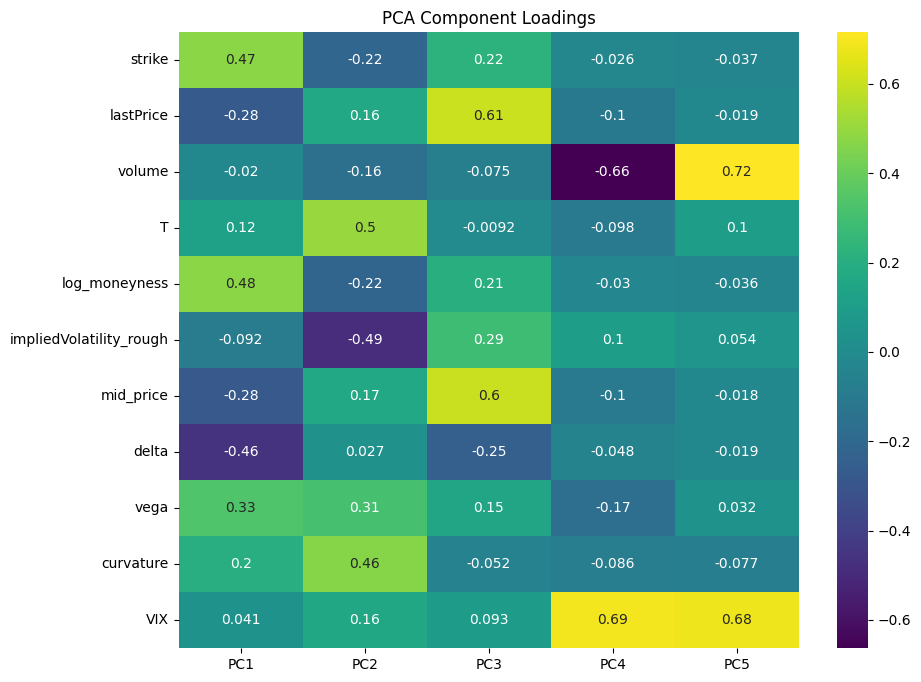

In [53]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'],
    index=data.columns)

plt.figure(figsize=(10, 8))
sns.heatmap(loadings, annot=True, cmap='viridis')
plt.title('PCA Component Loadings')
plt.show()

In [ ]:
print(y_train.describe())
print(y_test.describe())

In [ ]:
# Assuming y_train and y_test are your actual implied volatilities
plt.figure(figsize=(12, 6))

sns.histplot(y_train, kde=True, color='blue', label='Train Actual IV', alpha=0.5, bins=50)
sns.histplot(y_test, kde=True, color='red', label='Test Actual IV', alpha=0.5, bins=50)

plt.title('Distribution of Actual Implied Volatility (Train vs. Test)')
plt.xlabel('Actual Implied Volatility')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

##First xgboost

In [62]:
early_stop = xgb.callback.EarlyStopping(
    rounds=100, metric_name='rmse', data_name='validation_1', save_best=True
)
regression=xgb.XGBRegressor(tree_method="auto", n_estimators=1000, eval_metric='rmse', learning_rate=0.01,callbacks=[early_stop],random_state=42)
fitting=regression.fit(train_df,y_train, eval_set=[(train_df,y_train),(test_df, y_test)])
predictions=regression.predict(test_df)
predictions_train=regression.predict(train_df)

[0]	validation_0-rmse:0.26027	validation_1-rmse:0.16929
[1]	validation_0-rmse:0.25801	validation_1-rmse:0.16821
[2]	validation_0-rmse:0.25577	validation_1-rmse:0.16713
[3]	validation_0-rmse:0.25355	validation_1-rmse:0.16608
[4]	validation_0-rmse:0.25135	validation_1-rmse:0.16504
[5]	validation_0-rmse:0.24918	validation_1-rmse:0.16402
[6]	validation_0-rmse:0.24702	validation_1-rmse:0.16300
[7]	validation_0-rmse:0.24489	validation_1-rmse:0.16201
[8]	validation_0-rmse:0.24278	validation_1-rmse:0.16103
[9]	validation_0-rmse:0.24069	validation_1-rmse:0.16008
[10]	validation_0-rmse:0.23862	validation_1-rmse:0.15913
[11]	validation_0-rmse:0.23657	validation_1-rmse:0.15820
[12]	validation_0-rmse:0.23454	validation_1-rmse:0.15728
[13]	validation_0-rmse:0.23254	validation_1-rmse:0.15637
[14]	validation_0-rmse:0.23054	validation_1-rmse:0.15539
[15]	validation_0-rmse:0.22857	validation_1-rmse:0.15449
[16]	validation_0-rmse:0.22662	validation_1-rmse:0.15362
[17]	validation_0-rmse:0.22469	validation

###Metrics function

--- Baseline Model Metrics (test Set) ---
MSE: 0.0059
RMSE: 0.0770
MAE: 0.0311
Spearman corr: 0.9305
Spearman corr: 0.0000


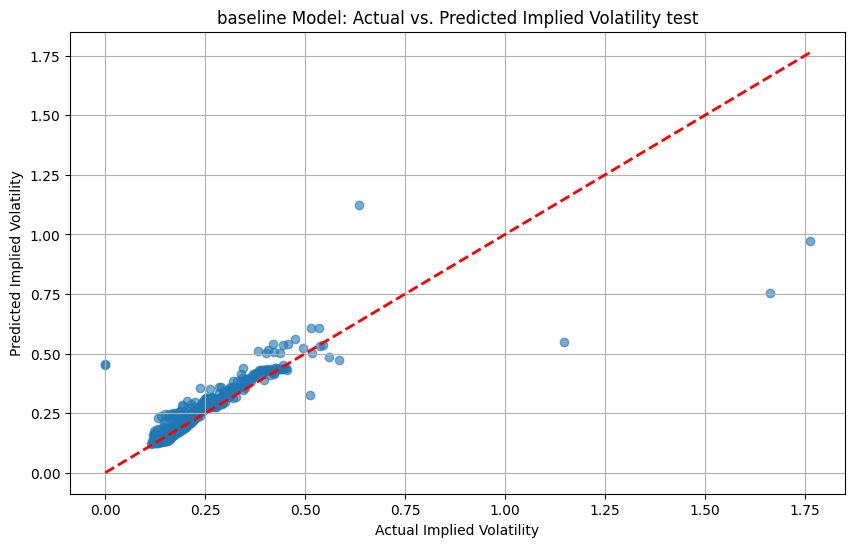

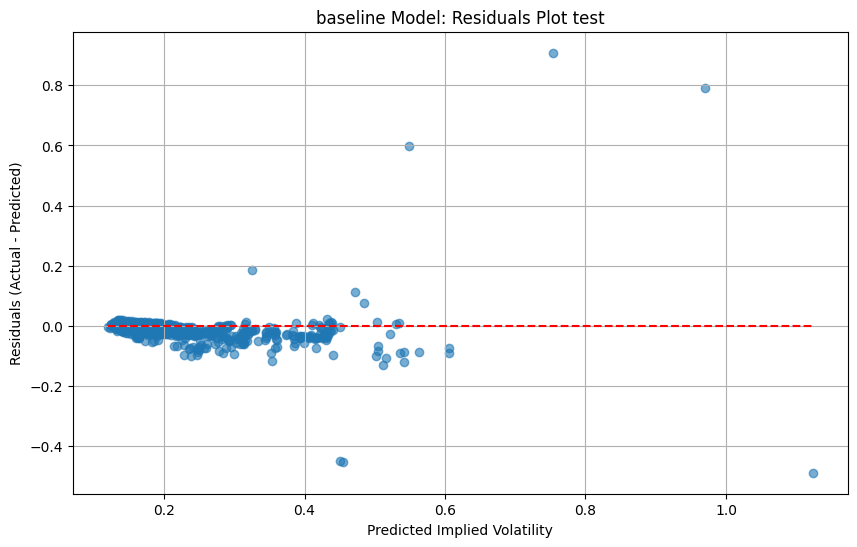

--- Baseline Model Metrics (train Set) ---
MSE: 0.0002
RMSE: 0.0140
MAE: 0.0088
Spearman corr: 0.9971
Spearman corr: 0.0000


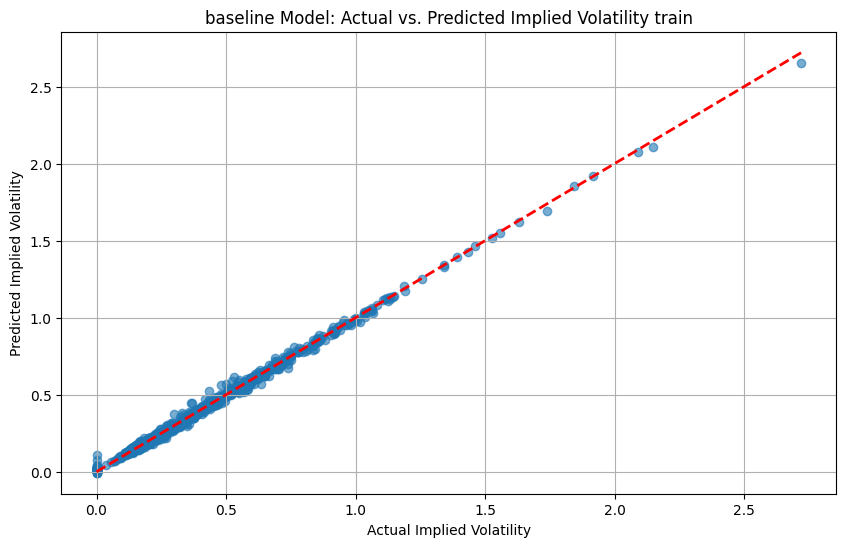

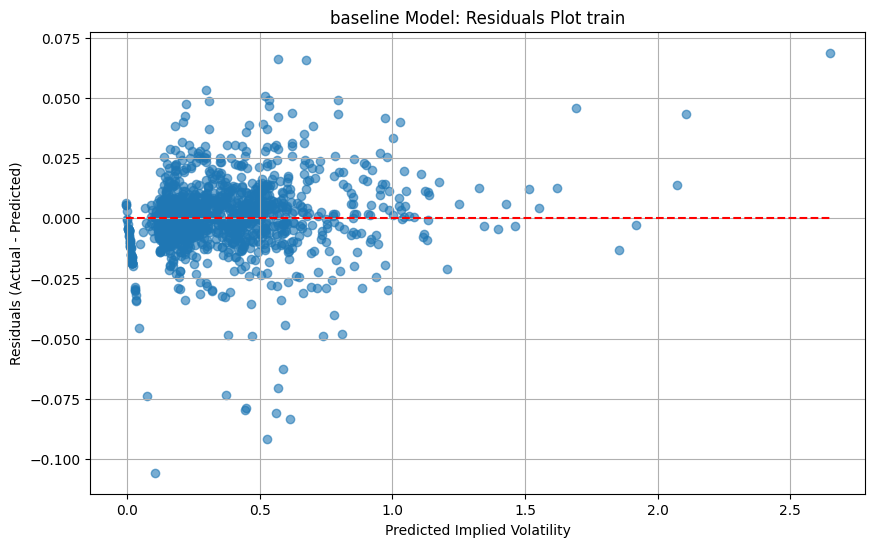

In [63]:
def metrics_function(df, actual, prediction,types,model):
  '''This function takes the train or test df,
  the actual values of Y, the predictions dpne by
  XGBoost and then two strings: types, indicating
  if it is train or test and model, considering if it is
  the first, the second or the last model'''

  mse_baseline = mean_squared_error(actual, prediction)
  rmse_baseline = np.sqrt(mse_baseline)
  mae_baseline = mean_absolute_error(actual, prediction)
  spearman = stats.spearmanr(actual, prediction)

  print(f"--- Baseline Model Metrics ({types} Set) ---")
  print(f"MSE: {mse_baseline:.4f}")
  print(f"RMSE: {rmse_baseline:.4f}")
  print(f"MAE: {mae_baseline:.4f}")
  print(f"Spearman corr: {spearman.statistic:.4f}")
  print(f"Spearman corr: {spearman.pvalue:.4f}")

  # You could store these in a dictionary or DataFrame for easy comparison later
  baseline_metrics = {
      'MSE': mse_baseline,
      'RMSE': rmse_baseline,
      'MAE': mae_baseline,
      'SPEARMAN CORR': spearman
  }

  # --- Optional: Visualizing Baseline Performance ---
  plt.figure(figsize=(10, 6))
  plt.scatter(actual, prediction, alpha=0.6)
  plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', lw=2)
  plt.xlabel("Actual Implied Volatility")
  plt.ylabel("Predicted Implied Volatility")
  plt.title(f"{model} Model: Actual vs. Predicted Implied Volatility {types}")
  plt.grid(True)
  plt.show()

  # Residuals plot
  plt.figure(figsize=(10, 6))
  residuals_baseline = actual - prediction
  plt.scatter(prediction, residuals_baseline, alpha=0.6)
  plt.hlines(0, prediction.min(), prediction.max(), colors='r', linestyles='--')
  plt.xlabel("Predicted Implied Volatility")
  plt.ylabel("Residuals (Actual - Predicted)")
  plt.title(f"{model} Model: Residuals Plot {types}")
  plt.grid(True)
  plt.show()

  return baseline_metrics

simple_xgboost_test=metrics_function(test_df,y_test, predictions,"test","baseline")
simple_xgboost_train=metrics_function(train_df,y_train, predictions_train,"train","baseline")

###Feature importance on first model using plot importance and shap

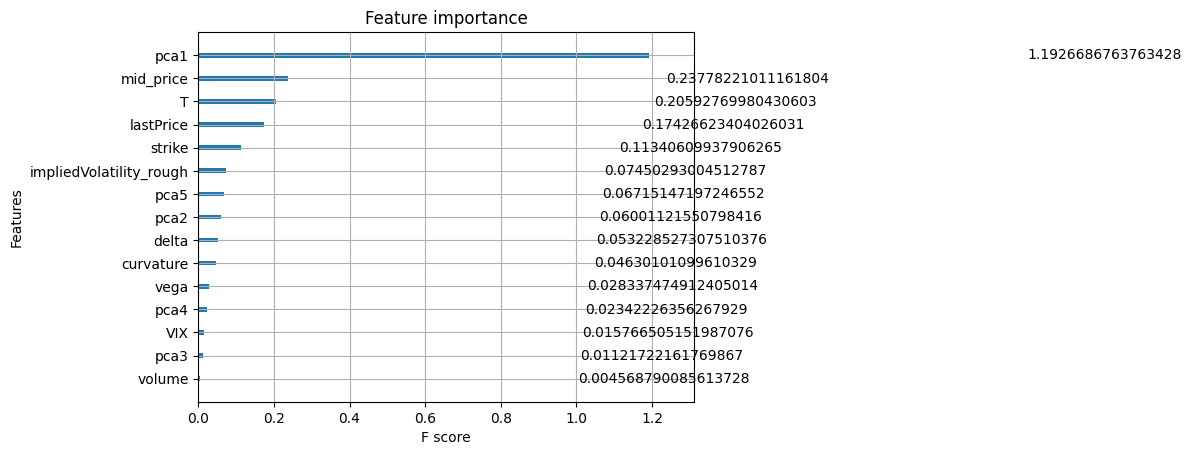

In [64]:
plot_importance(regression, importance_type='gain')  # 'weight', 'gain', 'cover' also available
plt.show()


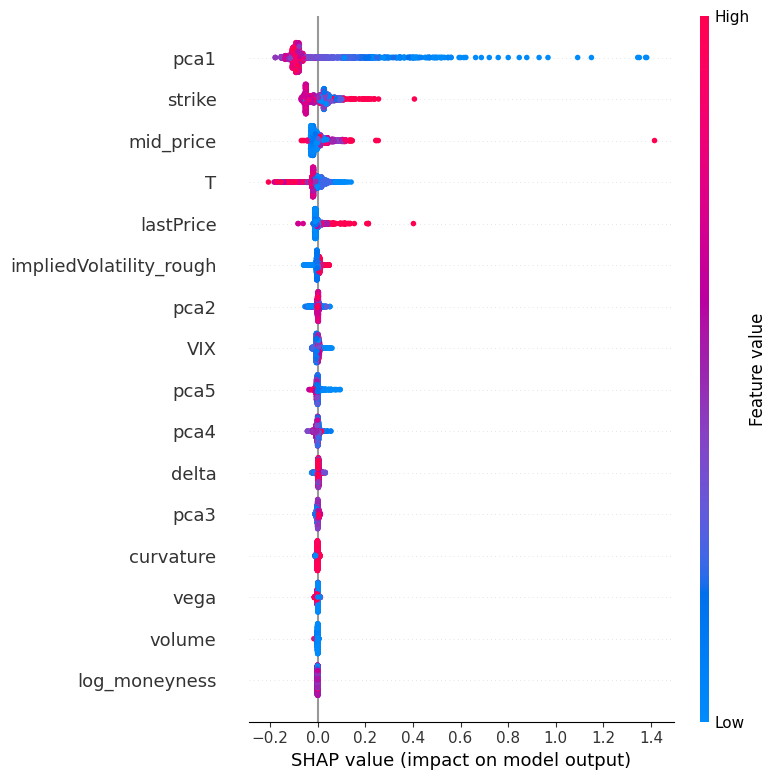

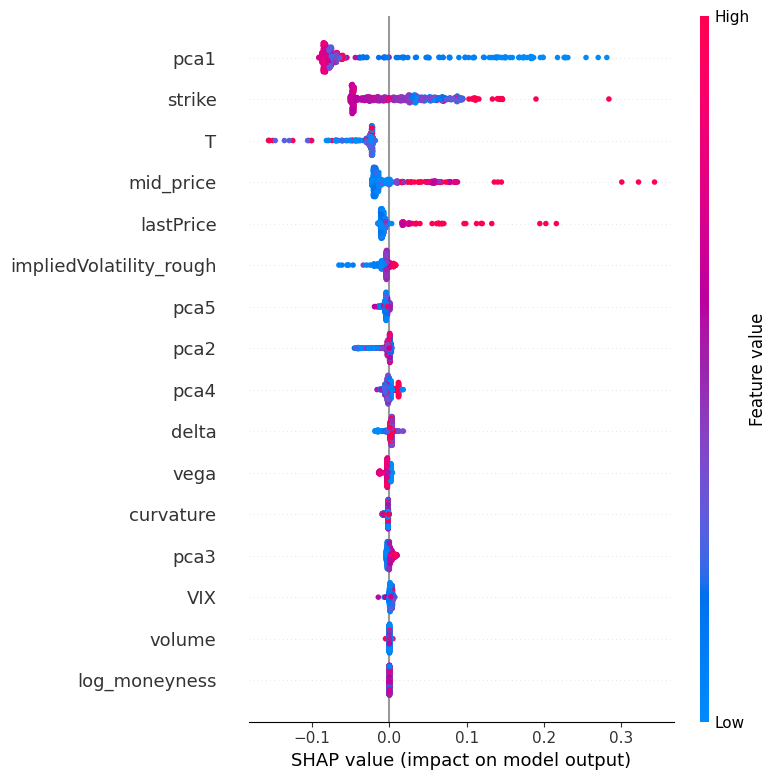

In [65]:
explainer = shap.TreeExplainer(regression)
shap_values = explainer.shap_values(train_df)
shap.summary_plot(shap_values, train_df)
shap_values = explainer.shap_values(test_df)
shap.summary_plot(shap_values, test_df)


##Second XGBoost with new variables

In [66]:
columns_to_drop=["pca3", "pca5","VIX","volume"]
train_df_new=train_df.drop(columns=columns_to_drop)
test_df_new=test_df.drop(columns=columns_to_drop)

In [67]:
early_stop = xgb.callback.EarlyStopping(
    rounds=100, metric_name='rmse', data_name='validation_1', save_best=True
)
regression_new = xgb.XGBRegressor(
    tree_method="auto",
    learning_rate=0.01,
    callbacks=[early_stop],
    n_estimators=1000,
    eval_metric='rmse',
    random_state=42# Increase max estimators to allow more iterations
)
fitting_new = regression_new.fit(
    train_df_new,
    y_train,
    eval_set=[(train_df_new,y_train),(test_df_new, y_test)],
    verbose=True # Add verbose to see if early stopping is being checked
)

[0]	validation_0-rmse:0.26028	validation_1-rmse:0.16929
[1]	validation_0-rmse:0.25803	validation_1-rmse:0.16821
[2]	validation_0-rmse:0.25579	validation_1-rmse:0.16714
[3]	validation_0-rmse:0.25358	validation_1-rmse:0.16608
[4]	validation_0-rmse:0.25140	validation_1-rmse:0.16504
[5]	validation_0-rmse:0.24923	validation_1-rmse:0.16402
[6]	validation_0-rmse:0.24709	validation_1-rmse:0.16301
[7]	validation_0-rmse:0.24497	validation_1-rmse:0.16202
[8]	validation_0-rmse:0.24285	validation_1-rmse:0.16103
[9]	validation_0-rmse:0.24076	validation_1-rmse:0.16006
[10]	validation_0-rmse:0.23869	validation_1-rmse:0.15911
[11]	validation_0-rmse:0.23664	validation_1-rmse:0.15817
[12]	validation_0-rmse:0.23461	validation_1-rmse:0.15718
[13]	validation_0-rmse:0.23262	validation_1-rmse:0.15627
[14]	validation_0-rmse:0.23063	validation_1-rmse:0.15537
[15]	validation_0-rmse:0.22866	validation_1-rmse:0.15441
[16]	validation_0-rmse:0.22670	validation_1-rmse:0.15352
[17]	validation_0-rmse:0.22478	validation

###Metrics

--- Baseline Model Metrics (test Set) ---
MSE: 0.0059
RMSE: 0.0765
MAE: 0.0307
Spearman corr: 0.9346
Spearman corr: 0.0000


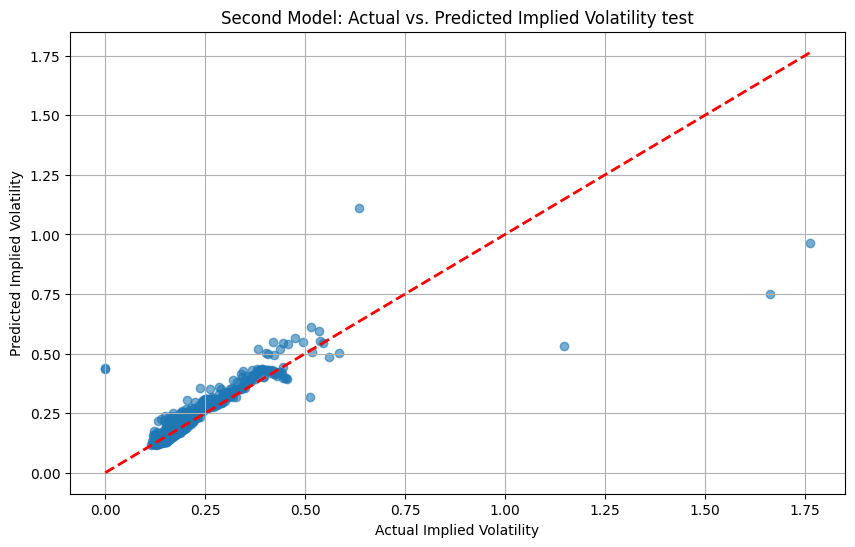

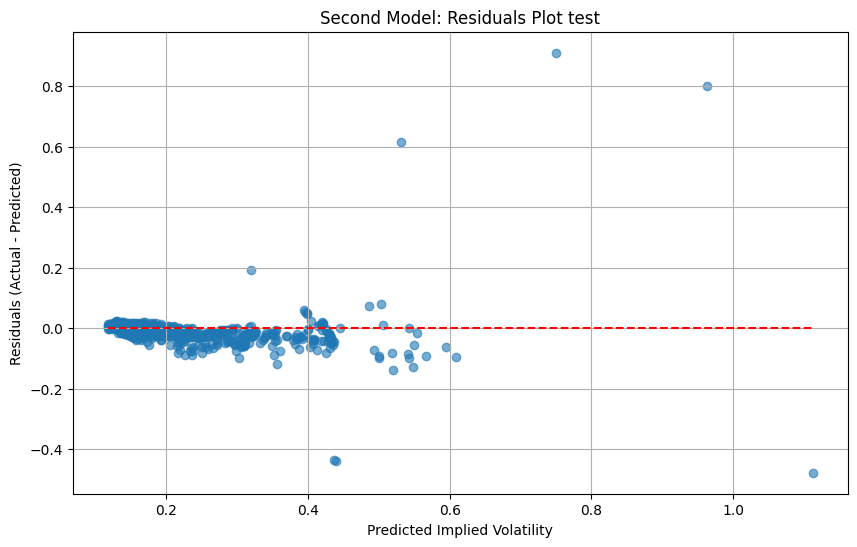

--- Baseline Model Metrics (train Set) ---
MSE: 0.0001
RMSE: 0.0117
MAE: 0.0074
Spearman corr: 0.9973
Spearman corr: 0.0000


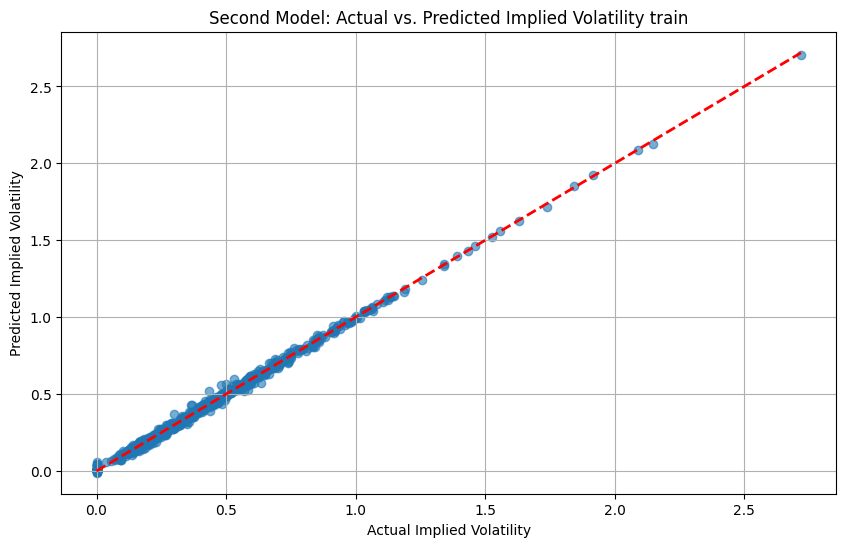

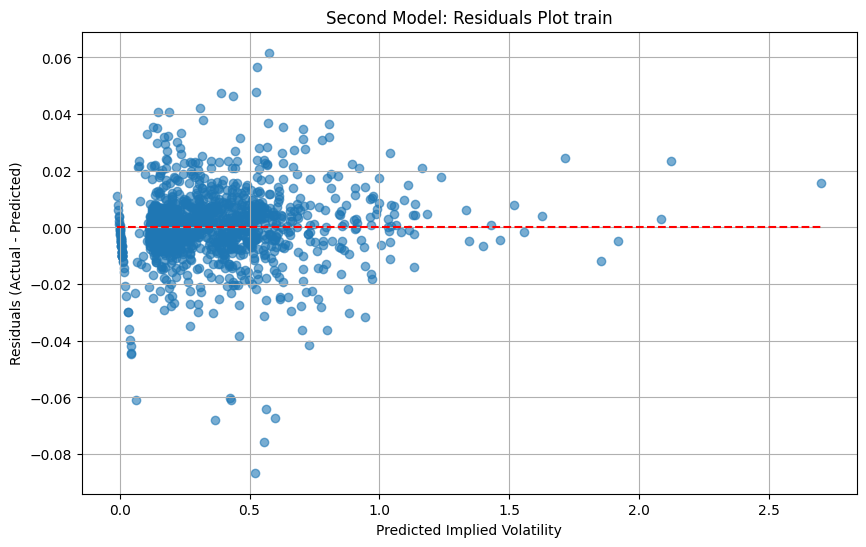

In [68]:
predictions_train_new=regression_new.predict(train_df_new)
predictions_test_new=regression_new.predict(test_df_new)

featured_xgboost=metrics_function(test_df_new,y_test, predictions_test_new, "test","Second")
featured_xgboost_train=metrics_function(train_df_new,y_train, predictions_train_new, "train","Second")

##Third xgboost after Hyperparameter tuning

In [69]:
params={"learning_rate":np.linspace(0.01,0.1,10),
        "n_estimators":[200,500,1000],
        "max_depth":[1,2,3,4,5],
        "min_child_weight":np.linspace(1,10,10),
        "gamma":np.linspace(0,1,10),
        "subsample":np.linspace(0.5,1,10),
        "reg_alpha":np.linspace(0,1,10),
        "reg_lambda":np.linspace(0,1,10)}

early_stop = xgb.callback.EarlyStopping(
    rounds=250, metric_name='rmse', data_name='validation_0', save_best=True
)
xgb_tuned = xgb.XGBRegressor(early_stopping_rounds=250, eval_metric="rmse") # The, random_state=42)
tuning= RandomizedSearchCV(estimator=xgb_tuned,param_distributions=params,random_state=42, n_iter=100, scoring="neg_mean_squared_error", cv=tscv,n_jobs=-1)
tuning.fit(train_df_new,y_train,eval_set=[(train_df_new,y_train),(test_df_new, y_test)])

model= tuning.best_estimator_
tuning.best_params_

[0]	validation_0-rmse:0.25821	validation_1-rmse:0.16835
[1]	validation_0-rmse:0.25399	validation_1-rmse:0.16639
[2]	validation_0-rmse:0.24987	validation_1-rmse:0.16441
[3]	validation_0-rmse:0.24587	validation_1-rmse:0.16254
[4]	validation_0-rmse:0.24194	validation_1-rmse:0.16072
[5]	validation_0-rmse:0.23820	validation_1-rmse:0.15900
[6]	validation_0-rmse:0.23442	validation_1-rmse:0.15725
[7]	validation_0-rmse:0.23085	validation_1-rmse:0.15562
[8]	validation_0-rmse:0.22719	validation_1-rmse:0.15407
[9]	validation_0-rmse:0.22366	validation_1-rmse:0.15250
[10]	validation_0-rmse:0.22018	validation_1-rmse:0.15080
[11]	validation_0-rmse:0.21679	validation_1-rmse:0.14929
[12]	validation_0-rmse:0.21348	validation_1-rmse:0.14785
[13]	validation_0-rmse:0.21018	validation_1-rmse:0.14627
[14]	validation_0-rmse:0.20694	validation_1-rmse:0.14480
[15]	validation_0-rmse:0.20377	validation_1-rmse:0.14353
[16]	validation_0-rmse:0.20068	validation_1-rmse:0.14202
[17]	validation_0-rmse:0.19765	validation

{'subsample': np.float64(0.8333333333333333),
 'reg_lambda': np.float64(0.3333333333333333),
 'reg_alpha': np.float64(0.8888888888888888),
 'n_estimators': 500,
 'min_child_weight': np.float64(1.0),
 'max_depth': 5,
 'learning_rate': np.float64(0.020000000000000004),
 'gamma': np.float64(0.0)}

###Metrics

--- Baseline Model Metrics (test Set) ---
MSE: 0.0086
RMSE: 0.0928
MAE: 0.0319
Spearman corr: 0.9355
Spearman corr: 0.0000


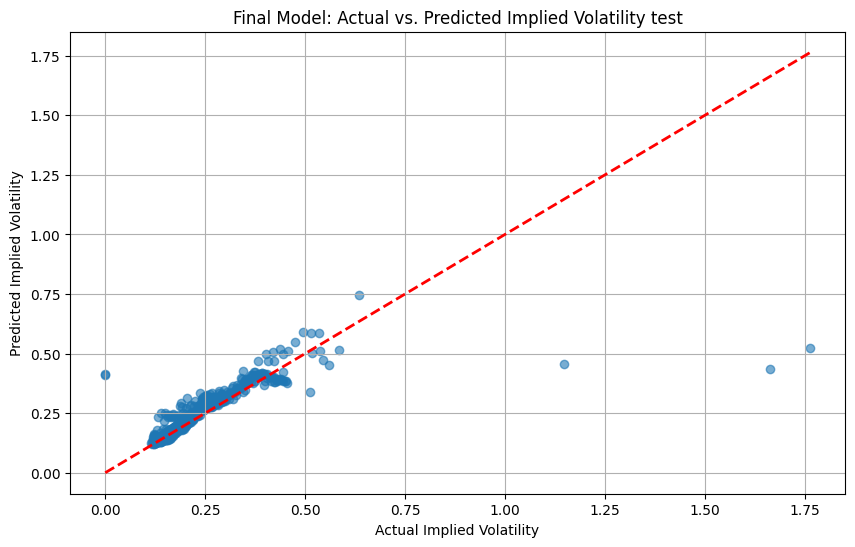

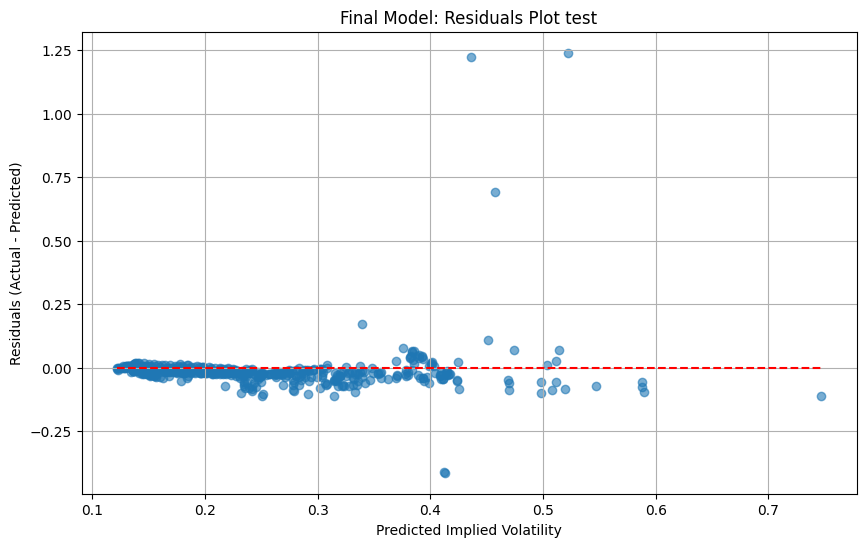

--- Baseline Model Metrics (train Set) ---
MSE: 0.0011
RMSE: 0.0330
MAE: 0.0143
Spearman corr: 0.9880
Spearman corr: 0.0000


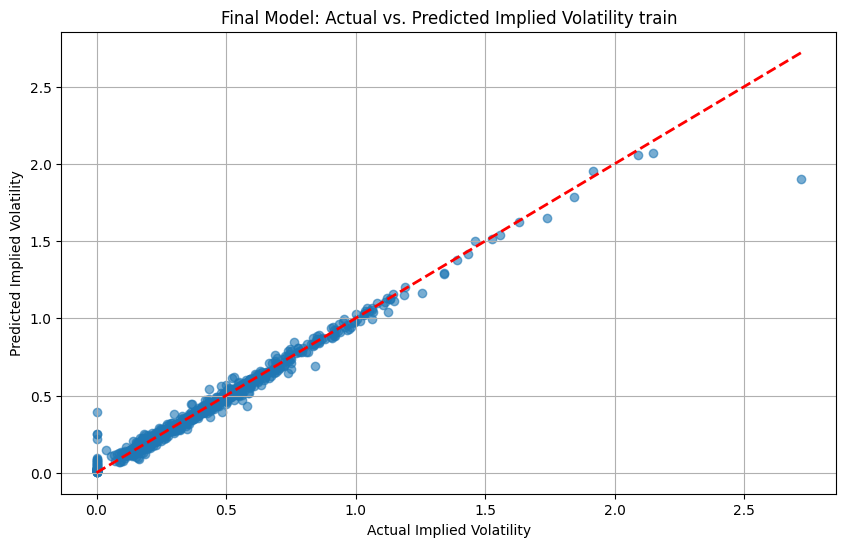

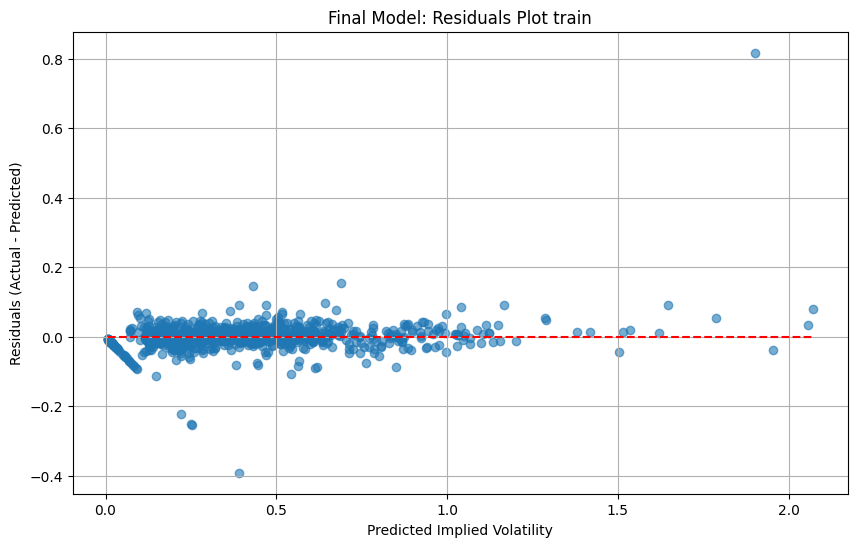

In [70]:
final_pred_train=model.predict(train_df_new)
final_pred_test=model.predict(test_df_new)

final_model_test=metrics_function(test_df_new,y_test, final_pred_test,"test","Final")
final_model_train=metrics_function(train_df_new,y_train, final_pred_train,"train","Final")

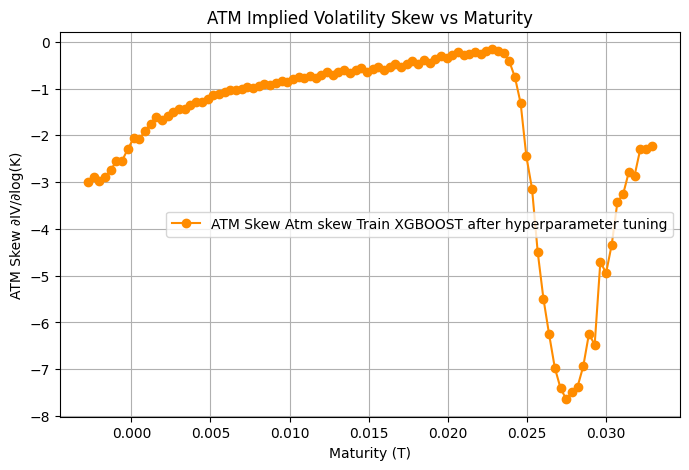

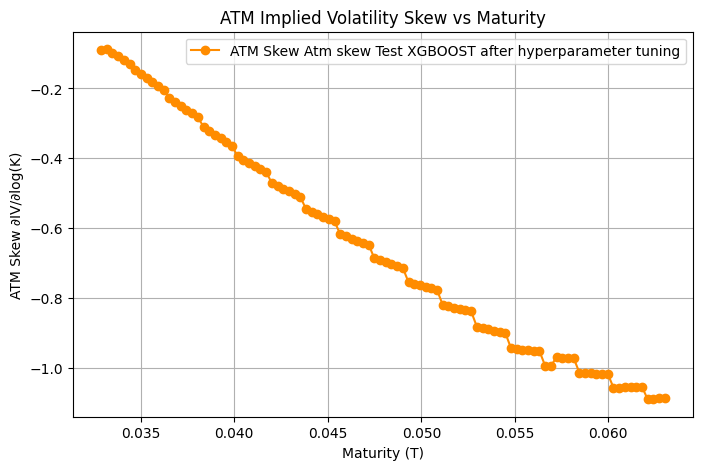

In [77]:
K_ml,T_ml,IV_ml=grid_for_atm(train_df_new["strike"].values,train_df_new["T"].values,final_pred_train,"cubic")
K_ml_test,T_ml_test,IV_ml_test=grid_for_atm(test_df_new["strike"].values,test_df_new["T"].values,final_pred_test,"cubic")
atm_skew_rough_ml = local_linear_atm_skew(T_ml, IV_ml, np.log(K_ml/spot), 0.2, "Atm skew Train XGBOOST after hyperparameter tuning")
atm_skew_rough_ml_test = local_linear_atm_skew(T_ml_test, IV_ml_test, np.log(K_ml_test/spot), 0.2,"Atm skew Test XGBOOST after hyperparameter tuning")

##Trading signals

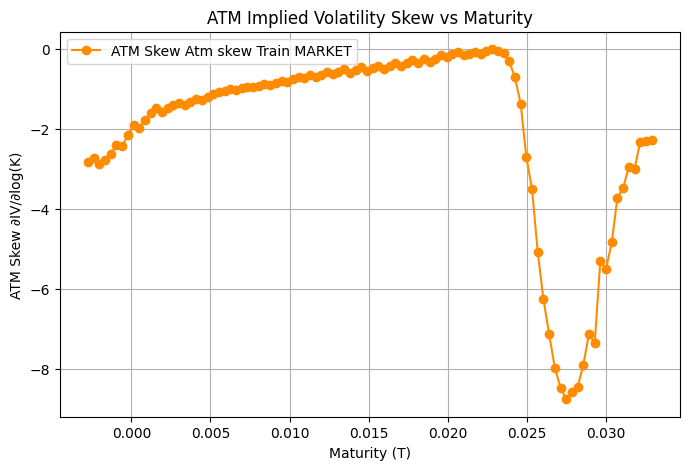

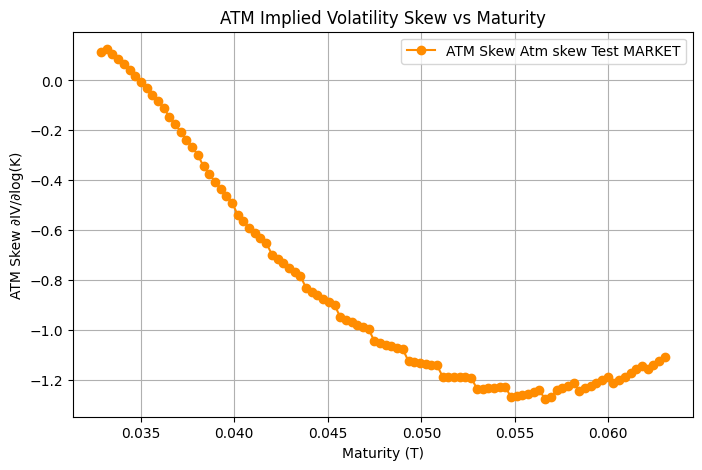

In [78]:
K_ml_m,T_ml_m,IV_ml_m=grid_for_atm(train_df_new["strike"].values,train_df_new["T"].values,y_train.values,"cubic")
K_ml_test_m,T_ml_test_m,IV_ml_test_m=grid_for_atm(test_df_new["strike"].values,test_df_new["T"].values,y_test.values,"cubic")
atm_skew_rough_mark = local_linear_atm_skew(T_ml_m, IV_ml_m, np.log(K_ml_m/spot), 0.2, "Atm skew Train MARKET")
atm_skew_rough_mark_t = local_linear_atm_skew(T_ml_test_m, IV_ml_test_m, np.log(K_ml_test_m/spot), 0.2,"Atm skew Test MARKET")

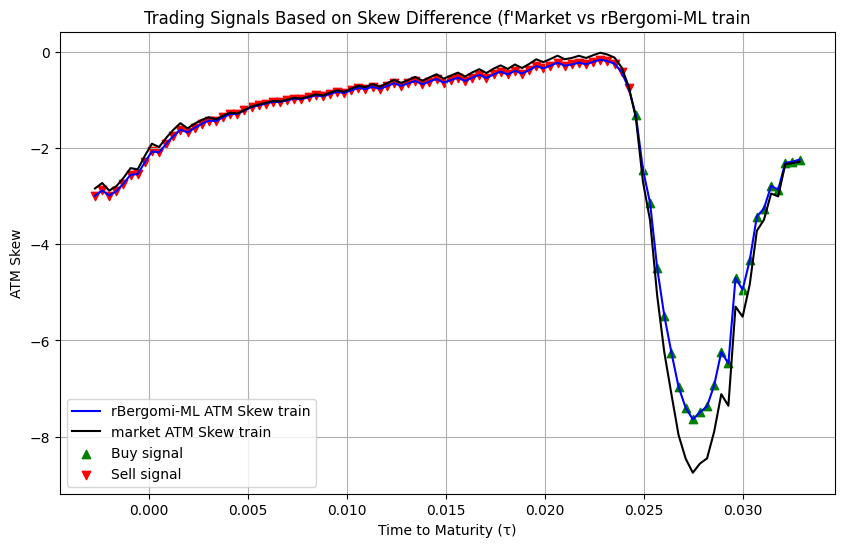

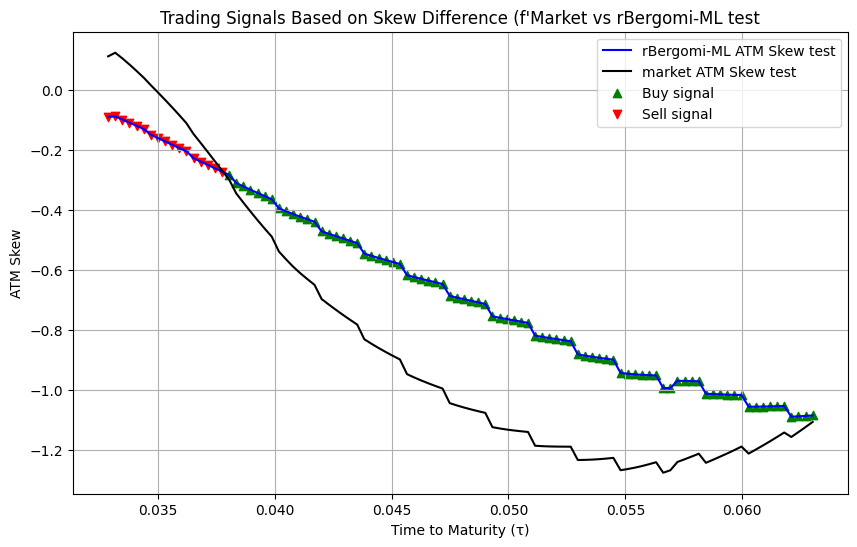

In [80]:
# Compute signal
def trading_signals(market,model, types):
  ''' It takes the market skew and the model skew for computing
  the difference and then it returns the plot by specifin the signal
  on the skew'''
  skew_signal = market[:, 1] - model[:, 1]

  # Separate buy/sell signals and associate with x-axis (e.g. maturity)
  skew_signal_buy_x = []
  skew_signal_buy_y = []
  skew_signal_sell_x = []
  skew_signal_sell_y = []

  for i in range(len(skew_signal)):
      x = model[i, 0]  # usually time to maturity or date
      if skew_signal[i] > 0:
          skew_signal_sell_x.append(x)
          skew_signal_sell_y.append(model[i, 1])  # model skew
      else:
          skew_signal_buy_x.append(x)
          skew_signal_buy_y.append(model[i, 1])

  # Plotting
  plt.figure(figsize=(10, 6))
  plt.plot(model[:, 0], model[:, 1], label=f'rBergomi-ML ATM Skew {types}', color='blue')
  plt.plot(market[:, 0], market[:, 1], label=f'market ATM Skew {types}', color='black')
  plt.scatter(skew_signal_buy_x, skew_signal_buy_y, color='green', marker='^', label='Buy signal')
  plt.scatter(skew_signal_sell_x, skew_signal_sell_y, color='red', marker='v', label='Sell signal')

  plt.xlabel("Time to Maturity (τ)")
  plt.ylabel("ATM Skew")
  plt.title(f"Trading Signals Based on Skew Difference (f'Market vs rBergomi-ML {types}")
  plt.legend()
  plt.grid(True)
  plt.show()

  return [skew_signal_buy_x,skew_signal_sell_x,skew_signal_buy_y,skew_signal_sell_y]

trading_signals_train=trading_signals(atm_skew_rough_mark,atm_skew_rough_ml,"train")
trading_signals_test=trading_signals(atm_skew_rough_mark_t,atm_skew_rough_ml_test,"test")
